In [ ]:
# default_exp download

# Downloading & Exploring the Input Data

<br>

### Imports

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import requests
from bs4 import BeautifulSoup as bs

import matplotlib.pyplot as plt
import FEAutils as hlp

<br>

### *ESAIL* Dataset

This dataset was initially developed by Patrick De Mars and Connor Galbraith, then updated and extended by Ayrton Bourn, all of whom were historically or are currently in the Energy Systems & AI Lab at UCL. 

Currently this dataset is missing key information such as the EIC code, capacity, and owners.

In [60]:
df_ESAIL = pd.read_csv('../data/raw/ESAIL.csv')

df_ESAIL.head()

,sett_bmu_id,ngc_bmu_id,bmu_root,name,primary_fuel_type,detailed_fuel_type,longitude,latitude
0,E_MARK-1,MARK-1,MARK,Rothes Bio-Plant CHP 1,biomass,bone,-3.603516,57.480403
1,E_MARK-2,MARK-2,MARK,Rothes Bio-Plant CHP 2,biomass,bone,-3.603516,57.480403
2,T_DIDC1,DIDC1,DIDC,Didcot A (G) 1,coal,coalgas_opt_out,-1.267570,51.623630
3,T_DIDC2,DIDC2,DIDC,Didcot A (G) 2,coal,coalgas_opt_out,-1.267570,51.623630
4,T_DIDC4,DIDC4,DIDC,Didcot A (G) 4,coal,coalgas_opt_out,-1.267570,51.623630


<br>

We can see how many entries we have

In [45]:
df_ESAIL.shape[0]

493

<br>

We can use `value_counts` to identify the most common fuel types, we can see that most of the plants are wind farms.

In [61]:
df_ESAIL['primary_fuel_type'].value_counts()

wind              147
gas                94
coal               74
fuel_oil           60
nuclear            34
run_of_river       31
pumped_storage     16
aggregator         14
other              10
rgt                 7
battery             3
biomass             3
Name: primary_fuel_type, dtype: int64

<br>

We'll quickly calculate the average number of BMU ids per location

In [62]:
avg_num_BMUs_per_loc = df_ESAIL['sett_bmu_id'].nunique()/df_ESAIL['bmu_root'].nunique()

print(f'The average number of BMU ids per location is {avg_num_BMUs_per_loc:.2f}')

The average number of BMU ids per location is 2.01


<br>

Its always useful to visualise this kind of data spatially so we'll load in a basemap with separate zones for each grid supply point

In [63]:
gdf_GSP_locs = gpd.read_file('../data/raw/GSP_shapefile/GSP_regions_20181031.shp')

gdf_GSP_locs.head()

,RegionID,RegionName,geometry
0,149,Beddington (_J),"POLYGON ((543750.561 167428.882, 549430.486 13..."
1,150,Northfleet East,"POLYGON ((571652.936 143992.711, 550968.129 13..."
2,155,Sellindge,"POLYGON ((624923.598 137169.470, 624894.947 13..."
3,160,Richborough,"POLYGON ((626375.397 137910.687, 623652.026 16..."
4,156,Chessington,"POLYGON ((523319.962 166572.557, 526121.634 14..."


<br>

We'll then overlay this with the power plant locations.

We can see trends such as run of river hydro in Scotland, as well as nuclear concentrated around the coast where there's easy access to cooling water. It also raises some potential errors, e.g. the fuel oil plant that is shown off the coast.

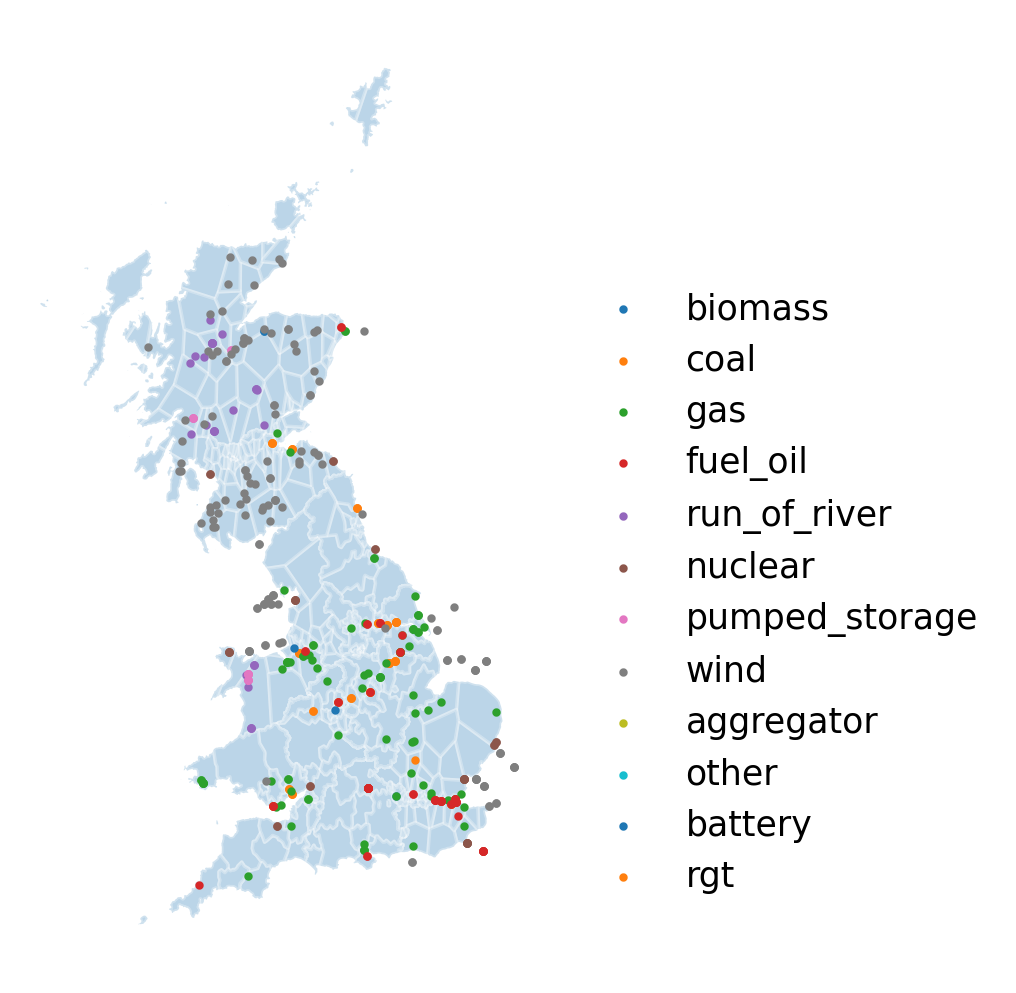

In [64]:
fuel_types = df_ESAIL['primary_fuel_type'].unique()

## Plotting
fig, ax = plt.subplots(figsize=(3, 5), dpi=250)

gdf_GSP_locs.to_crs('EPSG:4326').plot(ax=ax, alpha=0.3, edgecolor='w')

for fuel_type in fuel_types:
    df_fuel_specific = df_ESAIL[df_ESAIL['primary_fuel_type']==fuel_type]
    ax.scatter(df_fuel_specific['longitude'], df_fuel_specific['latitude'], s=2, alpha=1, label=fuel_type)

hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-9, 3)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.75))

<br>

### *Open Power System Data* Dataset

We want to make sure that we're always downloading the latest available dataset from OPSD so we'll identify which csv that is from their website

In [21]:
opsd_root = 'https://data.open-power-system-data.org'
page_url = f'{opsd_root}/conventional_power_plants/2020-10-01'

r = requests.get(page_url)

r

<Response [200]>

<br>

From this we can search for the csv and then extract the url that it refers to using `BeautifulSoup`

In [27]:
soup = bs(r.content)

csv_url = opsd_root + '/' + soup.find('a', string='conventional_power_plants_EU.csv')['href']
release_date = csv_url.split('/')[-2]

release_date

'2020-10-01'

<br>

We can now use `pandas` to load this directly into a dataframe

In [28]:
df_OPSD = pd.read_csv(csv_url)

df_OPSD.head()

,name,company,street,postcode,city,country,capacity,energy_source,technology,chp,...,type,lat,lon,eic_code,energy_source_level_1,energy_source_level_2,energy_source_level_3,additional_info,comment,source
0,Marcinelle Energie (Carsid),DIRECT ENERGIE,NaN,NaN,NaN,BE,413.0,Natural gas,Combined cycle,NaN,...,NaN,50.41396,4.40645,22WMARCIN000179H,Fossil fuels,Natural gas,NaN,NaN,NaN,https://www.elia.be/en/grid-data/power-generat...
1,Aalst Syral GT,Electrabel,NaN,NaN,NaN,BE,43.0,Natural gas,Gas turbine,Yes,...,CHP/IPP,NaN,NaN,NaN,Fossil fuels,Natural gas,NaN,NaN,NaN,https://www.elia.be/en/grid-data/power-generat...
2,Aalst Syral ST,Electrabel,NaN,NaN,NaN,BE,5.0,Natural gas,Steam turbine,Yes,...,CHP/IPP,NaN,NaN,NaN,Fossil fuels,Natural gas,NaN,NaN,NaN,https://www.elia.be/en/grid-data/power-generat...
3,AALTER TJ,Electrabel,NaN,NaN,NaN,BE,18.0,Oil,Gas turbine,NaN,...,NaN,NaN,NaN,NaN,Fossil fuels,Oil,NaN,NaN,NaN,https://www.elia.be/en/grid-data/power-generat...
4,Amercoeur 1 R TGV,Electrabel,NaN,NaN,NaN,BE,451.0,Natural gas,Combined cycle,NaN,...,NaN,50.43004,4.39518,22WAMERCO000010Y,Fossil fuels,Natural gas,NaN,NaN,NaN,https://www.elia.be/en/grid-data/power-generat...


<br>

We'll save this to our raw data directory before continuing

In [29]:
df_OPSD.to_csv('../data/raw/OPSD.csv', index=False)

<br>

We can see that there's roughly half the number of entries in the OPSD database for UK plants. However, its worth remembering that were ~2 entries per physcial location in the ESAIL dataset due to some plants having multiple BM units.

In [44]:
df_OPSD_UK = df_OPSD.query('country=="UK"')

df_OPSD_UK.shape[0]

244

<br>

Inspecting the break-down by fuel-type we start to see a slightly different picture though, where hydro takes the top spot and wind is no-where to be seen

In [47]:
df_OPSD_UK['energy_source'].value_counts()

Hydro                  130
Natural gas             48
Mixed fossil fuels      26
Non-renewable waste     13
Biomass and biogas      12
Nuclear                  8
Hard coal                7
Name: energy_source, dtype: int64

<br>

Visualising this difference for just the Hydro plants shows us that the OPSD dataset has far more granular information on some of the smaller run-of-river hydro plants in Scotland, however they do miss some run-of-river such as Rheidol in Wales.

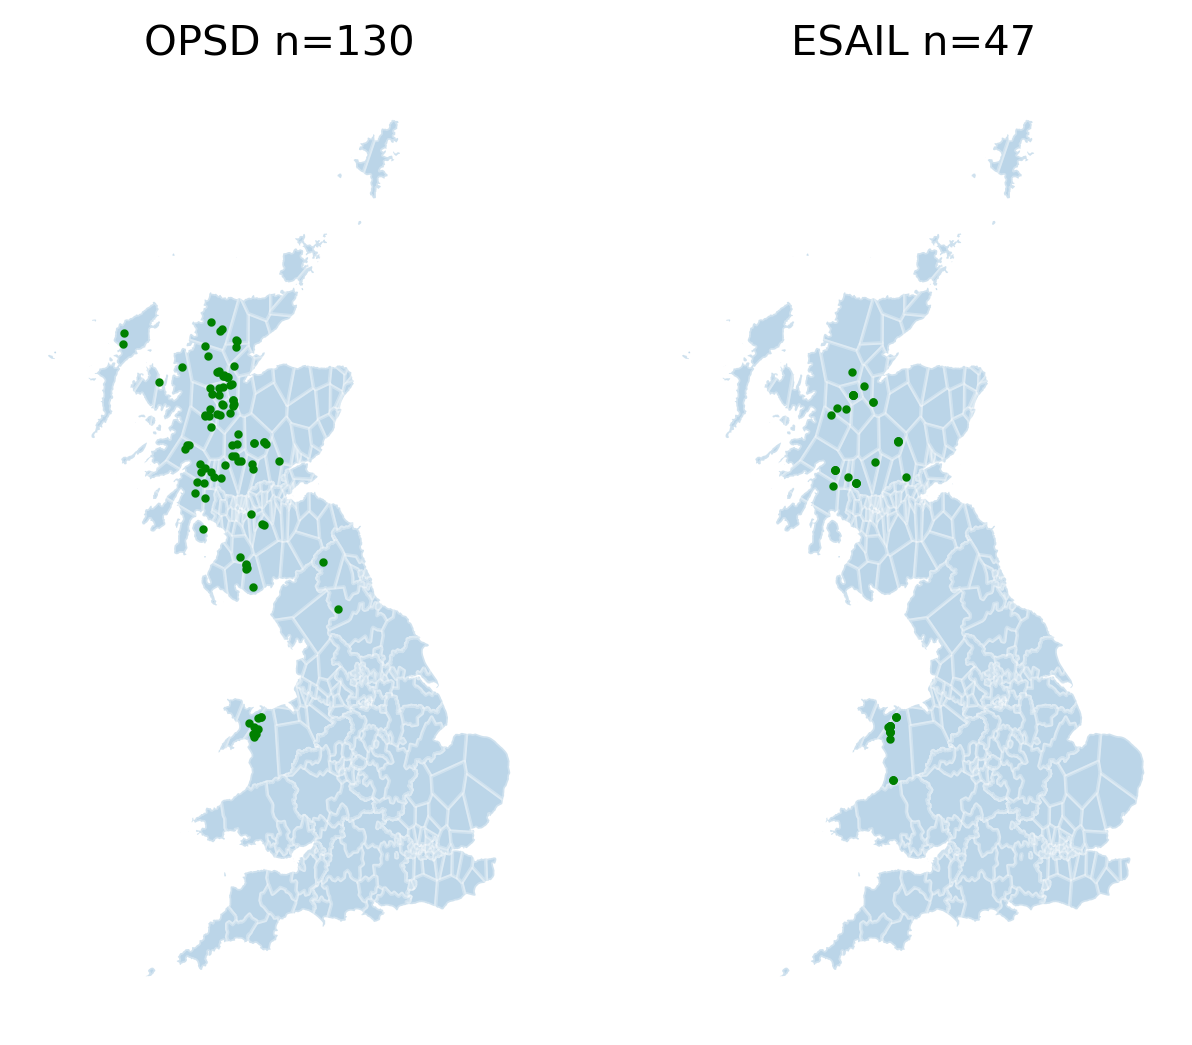

In [71]:
df_OPSD_UK_hydro = df_OPSD_UK.query('energy_source=="Hydro"')
df_ESAIL_hydro = df_ESAIL.query('primary_fuel_type=="run_of_river" | primary_fuel_type=="pumped_storage"')

# Plotting
fig, axs = plt.subplots(figsize=(6, 5), dpi=250, ncols=2)

ax = axs[0]
ax.set_title(f'OPSD n={df_OPSD_UK_hydro.shape[0]}')
gdf_GSP_locs.to_crs('EPSG:4326').plot(ax=ax, alpha=0.3, edgecolor='w')
ax.scatter(df_OPSD_UK_hydro['lon'], df_OPSD_UK_hydro['lat'], s=2, alpha=1, color='green')

ax = axs[1]
ax.set_title(f'ESAIL n={df_ESAIL_hydro.shape[0]}')
gdf_GSP_locs.to_crs('EPSG:4326').plot(ax=ax, alpha=0.3, edgecolor='w')
ax.scatter(df_ESAIL_hydro['longitude'], df_ESAIL_hydro['latitude'], s=2, alpha=1, color='green')

for ax in axs:
    hlp.hide_spines(ax, positions=['top', 'bottom', 'left', 'right'])
    ax.set_xticks([])
    ax.set_yticks([])

<br>

We'll also look at the detail to which they go in for energy sources

In [75]:
df_OPSD[['energy_source_level_1', 'energy_source_level_2', 'energy_source_level_3']].drop_duplicates()

,energy_source_level_1,energy_source_level_2,energy_source_level_3
0,Fossil fuels,Natural gas,NaN
3,Fossil fuels,Oil,NaN
5,Renewable energy,Bioenergy,Biomass and biogas
8,Renewable energy,Hydro,NaN
12,Nuclear,NaN,NaN
25,Fossil fuels,Non-renewable waste,NaN
53,Fossil fuels,Mixed fossil fuels,NaN
93,Fossil fuels,Hard coal,NaN
109,Other or unspecified energy sources,NaN,NaN
313,Fossil fuels,Lignite,NaN


In [ ]:
#hide
from nbdev.export import *
notebook2script()